In [27]:
import numpy  as np
import pandas as pd

from vega import VegaLite

import matplotlib.pyplot as plt

from imageio           import imread, imsave
from skimage.transform import resize
from skimage.color     import rgb2grey
from skimage.util      import view_as_blocks

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [2]:
data_dir = "../csvs"

In [3]:
def load_data (run, prefix="", rolling=30, thing="loss"):
    
    assert thing in ["loss", "accuracy"]

    df1 = pd.read_csv(f"{data_dir}/experiments_{run}-train_data.csv")
    df1 = df1.rolling(rolling).mean()

    df2 = pd.read_csv(f"{data_dir}/experiments_{run}-val_data.csv")
    df2 = df2.rolling(rolling).mean()

    df = pd.merge(df1, df2, left_on="step", right_on="step",
                 suffixes=["_train","_val"])
    
    return df

In [4]:
def view_graph (df):
    g = VegaLite({
          "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
          "width": 700, "height": 400,
          "layer": 
            [
            # Training
              { "mark": { "type": "line", "interpolate": "basis" },
              "encoding": {
                "x":       {"field": "step",       "type": "quantitative", "axis": {"title": "Step"}},
                "y":       {"field": "loss_train", "type": "quantitative", "axis": {"title": "Value"}},
                "color":   {"field": "Experiment", "type": "nominal"},
                "tooltip": {"field": "Experiment", "type": "nominal"}
              }      
            }

            # Validation
            , { "mark": { "type": "line", "interpolate": "basis", "strokeDash": [4,4] },
              "encoding": {
                "x":       {"field": "step",       "type": "quantitative", "axis": {"title": "Step"}},
                "y":       {"field": "loss_val",   "type": "quantitative", "axis": {"title": "Value"}},
                "color":   {"field": "Experiment", "type": "nominal"},
                "tooltip": {"field": "Experiment", "type": "nominal"}
              }
            }
          ]

        }, df)
    return g

In [5]:
dfs    = []

for y in [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    for x in ["", "-augx10"]:
        df = load_data(f"{y}{x}", prefix=f"{y}{x}", thing="loss")
        df["Experiment"] = f"{y}{x}"
        dfs.append(df)
    

df = pd.concat(dfs)
df = df.drop(columns=["Unnamed: 0_train", "Unnamed: 0_val"])
df = df.dropna()
df = df.reset_index()

In [6]:
df.to_json("train-val-curves.json", orient="records")

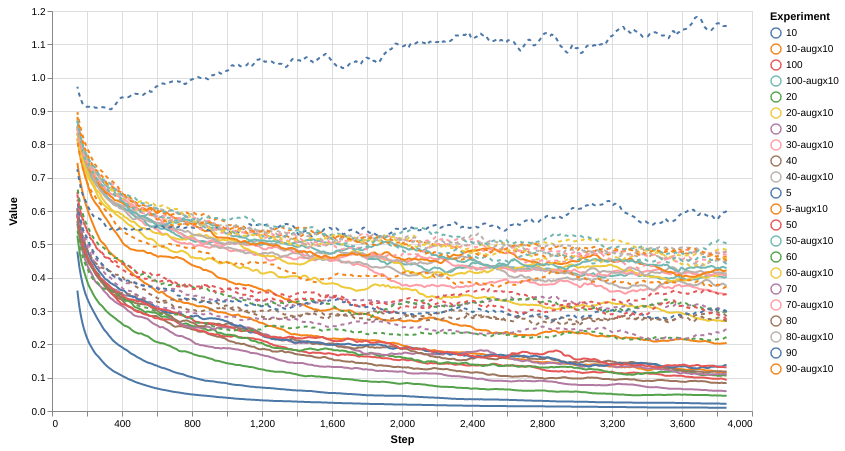

In [7]:
view_graph(df)

In [8]:
def holdout_threshold (run, threshold = 0.5):
    df = pd.read_csv(f"{data_dir}/experiments_{run}-results.csv")
    df["correct"] = df.apply(lambda row: row["predicted_" + row["true_label"]] 
                             > threshold, 1)
    return df 

def holdout_accuracy_threshold (run, threshold = 0.5):
    df  = holdout_threshold(run, threshold)
    acc = df["correct"].sum() / len(df)
    return acc


def holdout_max (run):
    df = pd.read_csv(f"{data_dir}/experiments_{run}-results.csv")
    
    def was_right (row):
        cols = [c for c in row.keys() if c.startswith("predicted")]
        best = ""
        last = 0
        
        for c in cols:
            name = c.split("_")[1]
            v    = float(row[c])
            if v > last:
                best = name
                last = v
        
        return best == row["true_label"]
    
    df["correct"] = df.apply(was_right, 1)
    return df

def holdout_accuracy_max (run):
    df  = holdout_max(run)
    acc = df["correct"].sum() / len(df)
    return acc

In [9]:
holdout_accuracy_max("just-1-image")

0.6758241758241759

In [10]:
data = []

for k in ["1", "3", 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    for x in ["", "-augx10"]:
        try:
            run = f"{k}{x}"
            acc = holdout_accuracy_max(run)
            data.append({"Experiment": run, "Accuracy": np.round(acc, 3)})
        except:
            pass

df = pd.DataFrame(data)
df = df.dropna()
df = df.reset_index()

In [11]:
def view_accuracy_graph (df):
    g = VegaLite({
          "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
          "width": 700, "height": 400,
          "mark": { "type": "bar", "interpolate": "basis" },
          "encoding": {
            "y": {"field": "Experiment", "type": "nominal",
                  "sort": {"field": "Accuracy", "op": "average", "order": "ascending"}
                 },
            "x": {"field": "Accuracy",   "type": "quantitative", "axis": { "grid": True },
                  "scale": { "domain": [0,1] }
                 },
            "selection": { "grid": { "type": "interval", "bind": "scales" }  },
            "tooltip": {"field": "Accuracy", "type": "quantitative"}
          }
        }, df)
    
    return g

In [12]:
df.to_json("holdout-accuracies.json", orient="records")

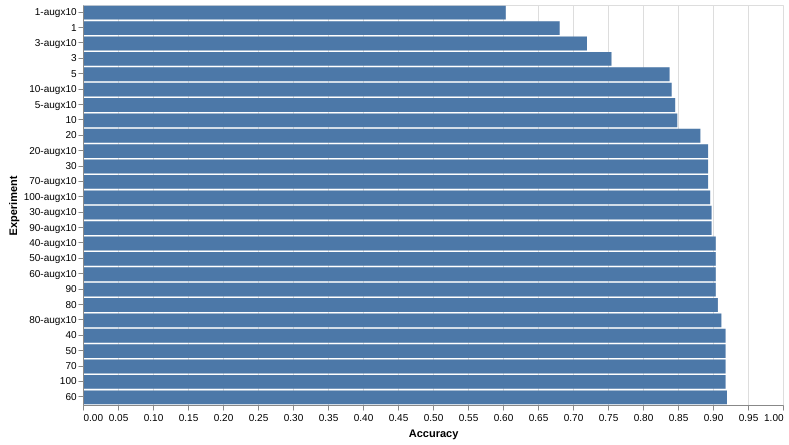

In [13]:
view_accuracy_graph(df)

In [84]:
w = 120
h = 80

def load_image (preds, filename):
    row = preds[preds.file_name == filename]
        
    i = imread(f"../{filename}")
    i = resize(i, [h, w, 3], mode="reflect")
    
    if not(row["correct"].values[0]):
        cols = [c for c in row.columns if c.startswith("predicted")]
        best = ""
        last = 0
        
        for c in cols:
            name = c.split("_")[1]
            v    = row[c].values[0]
            if v > last:
                best = name
                last = v
            
        text   = best
        colour = 255,0,0

        img  = Image.fromarray(np.uint8(i*255))
        draw = ImageDraw.Draw(img)
        ttf  = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
        font = ImageFont.truetype(ttf, 22)

        draw.rectangle(((0, 0), (w, 23)), fill="black")
        draw.text((0, 0), text, colour, font=font)

        i = np.array(img) / 255

    else:
        pass
        # text  = row["true_label"].values[0]
        # colour = 255, 255, 255

    i = np.expand_dims(i, 0)
    
    return i, row["correct"].values[0]

In [85]:
def grid (im_in, ncols=3):
    n,h,w,c = im_in.shape
    dn      = (-n)%ncols # trailing images
    im_out  = (np.empty((n+dn)*h*w*c,im_in.dtype)
              .reshape(-1,w*ncols,c))
    
    view = view_as_blocks(im_out,(h,w,c))
    
    for k,im in enumerate( list(im_in) + dn*[0] ):
        view[k//ncols,k%ncols,0] = im
        
    return im_out

In [91]:
b = np.ones((10,4,3))
b = np.concatenate([ np.zeros((2, 4, 3)), b ])

In [92]:
b.shape

(12, 4, 3)

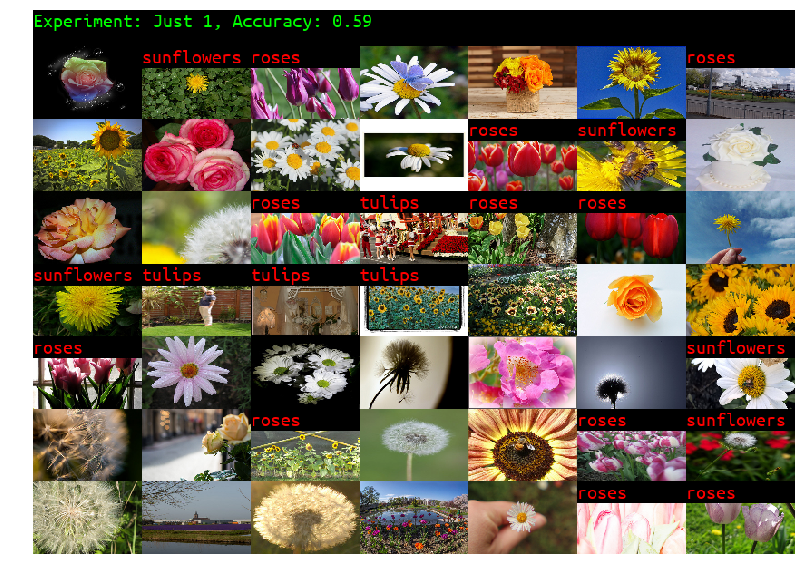

In [102]:
def grid_for_run(run, fns=None, title="", rows=7, cols=7):
    preds = holdout_max("{}".format(run))
    
    if fns is None:
        fns   = preds.sample(n=rows*cols)["file_name"].values

    images_and_accs = [ load_image(preds, fn) for fn in fns ]
    right  = len([ 1 for i, acc in images_and_accs if acc ])
    wrong  = len(images_and_accs) - right
    
    acc = right / (right + wrong)
t    
    images = [ i for i, acc in images_and_accs ]
    images = np.concatenate(images)

    a = grid(images, ncols=cols)
    a = np.concatenate([np.zeros((40, a.shape[1], a.shape[2])), a])
    
    img  = Image.fromarray(np.uint8(a*255))
    draw = ImageDraw.Draw(img)
    ttf  = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
    font = ImageFont.truetype(ttf, 22)
    text = "Experiment: {}, Accuracy: {}".format(title, np.round(acc, 2))

    ww = cols * w
    draw.rectangle(((0, 0), (ww, 23)), fill="black")
    draw.text((0, 0), text, (0, 255, 0), font=font)

    a = np.array(img)
    
    return np.uint8(a)

a = grid_for_run("1", title="Just 1")

plt.axis("Off")
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(a);

In [103]:
preds = holdout_max("{}".format(run))
rows  = 7
cols  = 7
fns   = preds.sample(n=rows*cols)["file_name"].values

for k, amount in enumerate(["1", "3", 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    title = "{}%".format(amount)
    if type(amount) is str:
        title = "Just {} image(s)".format(amount)
        
    a = grid_for_run(amount, fns=fns, title=title)
    imsave("../gif-images/{:02}.png".format(k), a)